In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
from sqlalchemy import create_engine
from sklearn.model_selection import GridSearchCV

# Function to record performance metrics to a CSV
def log_results_to_csv(model_name, hyperparameters, accuracy, auc, sensitivity, specificity, confusion_matrix, classification_report, filename='(Full_Dataset)f_model_eval_log.csv'):
    results = {
        'Model': model_name,
        'Hyperparameters': str(hyperparameters),
        'Accuracy': accuracy,
        'AUC': auc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Confusion Matrix': str(confusion_matrix),
        'Classification Report': str(classification_report)
    }
    # Convert to DataFrame and append
    results_df = pd.DataFrame([results])
    
    try:
        results_df.to_csv(filename, mode='a', header=False, index=False)
    except FileNotFoundError:
        # If file doesn't exist, create it with headers
        results_df.to_csv(filename, mode='w', header=True, index=False)

# Load the diabetes dataset
engine = create_engine('sqlite:///(Full_Dataset)diabetesData.db')
diabetes_df = pd.read_sql_query('select * from diabetes', con=engine)

# Define features set and target vector
X = diabetes_df.drop("diabetes", axis=1)
y = diabetes_df["diabetes"].to_numpy()

# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Model 1. Random Forest

In [3]:
# --- Model 1: Initial Random Forest Classifier (Baseline Model) ---
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)
rf_model.fit(X_train_scaled, y_train)

# Make predictions and evaluate model
predictions = rf_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep = classification_report(y_test, predictions)

# Calculate AUC: ROC-AUC score for binary classification
auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm.ravel()
sensitivity_rf = TP / (TP + FN)
specificity_rf = TN / (TN + FP)

# Log results for the baseline model to csv
log_results_to_csv('RandomForestClassifier', {'n_estimators': 500}, accuracy, auc_rf, sensitivity_rf, specificity_rf, cm_df, classification_rep)

Model 2. Logistic Regression

In [18]:
# --- Model 2: Logistic Regression ---
lr_model = LogisticRegression(random_state=78)
lr_model.fit(X_train_scaled, y_train)

# Make predictions and evaluate model
predictions_lr = lr_model.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, predictions_lr)
cm_lr = confusion_matrix(y_test, predictions_lr)
cm_df_lr = pd.DataFrame(cm_lr, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_lr = classification_report(y_test, predictions_lr)

# Calculate AUC: ROC-AUC score for binary classification
auc_lr = roc_auc_score(y_test, lr_model.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_lr.ravel()
sensitivity_lr = TP / (TP + FN)
specificity_lr = TN / (TN + FP)

# Log results for the Logistic Regression model to csv
log_results_to_csv('LogisticRegression', {'solver': 'lbfgs'}, accuracy_lr, auc_lr, sensitivity_lr, specificity_lr, cm_df_lr, classification_rep_lr)

# --- Model 2.5: Optimized Logistic Regression ---

# Hyperparameter grid for LogisticRegression
param_grid_lr = {
    'C': [None, 0.01, 0.1, 1, 10],
    'penalty': [None, 'l1', 'l2'],
    'solver': ['liblinear', 'lbfgs']
}

# GridSearchCV for LogisticRegression
lr_grid_search = GridSearchCV(LogisticRegression(random_state=78), param_grid_lr, cv=5, n_jobs=-1, scoring='accuracy')
lr_grid_search.fit(X_train_scaled, y_train)

# Best model after GridSearchCV
lr_optimized = lr_grid_search.best_estimator_

# Log results for the optimized Logistic Regression model
predictions_lr_optimized = lr_optimized.predict(X_test_scaled)
accuracy_lr_optimized = accuracy_score(y_test, predictions_lr_optimized)
cm_lr_optimized = confusion_matrix(y_test, predictions_lr_optimized)
cm_df_lr_opt = pd.DataFrame(cm_lr_optimized, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_lr_opt = classification_report(y_test, predictions_lr_optimized)

# Calculate AUC: ROC-AUC score for binary classification
auc_lr_opt = roc_auc_score(y_test, lr_optimized.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_lr.ravel()
sensitivity_lr_opt = TP / (TP + FN)
specificity_lr_opt = TN / (TN + FP)

# Log the results of the  optimized Logistic Regression Model to csv
log_results_to_csv('LogisticRegression_Optimized', lr_grid_search.best_params_, accuracy_lr_optimized, auc_lr_opt, sensitivity_lr_opt, specificity_lr_opt, cm_df_lr_opt, classification_rep_lr_opt)

c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
70 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Use

Model 3. Decision Tree

In [5]:
# --- Model 3: Decision Tree Classifier ---
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=78)
dt_model.fit(X_train_scaled, y_train)

# Make predictions and evaluate model
predictions_dt = dt_model.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test, predictions_dt)
cm_dt = confusion_matrix(y_test, predictions_dt)
cm_df_dt = pd.DataFrame(cm_dt, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_dt = classification_report(y_test, predictions_dt)

# Calculate AUC: ROC-AUC score for binary classification
auc_dt = roc_auc_score(y_test, dt_model.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_dt.ravel()
sensitivity_dt = TP / (TP + FN)
specificity_dt = TN / (TN + FP)

# Log the results of the Decision Tree Classifier model to csv
log_results_to_csv('DecisionTreeClassifier', {'max_depth': None}, accuracy_dt, auc_dt, sensitivity_dt, specificity_dt, cm_df_dt, classification_rep_dt)

# --- Model 3.5: Decision Tree Classifier Optimized ---

# Hyperparameter grid for DecisionTreeClassifier
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [None, 2, 5, 10],
    'min_samples_leaf': [None, 1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# GridSearchCV for DecisionTreeClassifier
dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=78), param_grid_dt, cv=5, n_jobs=-1, scoring='accuracy')
dt_grid_search.fit(X_train_scaled, y_train)

# Best model after GridSearchCV
dt_optimized = dt_grid_search.best_estimator_

# Log results for the optimized DecisionTreeClassifier model
predictions_dt_optimized = dt_optimized.predict(X_test_scaled)
accuracy_dt_optimized = accuracy_score(y_test, predictions_dt_optimized)
cm_dt_optimized = confusion_matrix(y_test, predictions_dt_optimized)
cm_df_dt_opt = pd.DataFrame(cm_dt_optimized, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_dt_opt = classification_report(y_test, predictions_dt_optimized)

# Calculate AUC: ROC-AUC score for binary classification
auc_dt_opt = roc_auc_score(y_test, dt_optimized.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_dt_optimized.ravel()
sensitivity_dt_opt = TP / (TP + FN)
specificity_dt_opt = TN / (TN + FP)

# Log results for the optimized DecisionTreeClassifier model to csv
log_results_to_csv('DecisionTreeClassifier_Optimized', dt_grid_search.best_params_, accuracy_dt_optimized, auc_dt_opt, sensitivity_dt_opt, specificity_dt_opt, cm_df_dt_opt, classification_rep_dt_opt)

c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
420 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\U

Model 4. SVC/SVM Model ------- DO NOT RUN THIS ONE!!!!

Model 5. KNearestNeighbors

In [6]:
# --- Model 5: KNNeighbors Model ---
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

# Make predictions and evaluate model
predictions_knn = knn_model.predict(X_test_scaled)
accuracy_knn = accuracy_score(y_test, predictions_knn)
cm_knn = confusion_matrix(y_test, predictions_knn)
cm_df_knn = pd.DataFrame(cm_knn, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_knn = classification_report(y_test, predictions_knn)

# Calculate AUC: ROC-AUC score for binary classification
auc_knn = roc_auc_score(y_test, knn_model.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_knn.ravel()
sensitivity_knn = TP / (TP + FN)
specificity_knn = TN / (TN + FP)

# Log the results of the KNN Model to csv
log_results_to_csv('KNN', {'n_neighbors': 5}, accuracy_knn, auc_knn, sensitivity_knn, specificity_knn, cm_df_knn, classification_rep_knn)

Model 6. GaussianNB

In [7]:
# --- Model 6: Naive Bayes/GaussianNB Model ---
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

# Make predictions and evaluate model
predictions_nb = nb_model.predict(X_test_scaled)
accuracy_nb = accuracy_score(y_test, predictions_nb)
cm_nb = confusion_matrix(y_test, predictions_nb)
cm_df_nb = pd.DataFrame(cm_nb, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_nb = classification_report(y_test, predictions_nb)

# Calculate AUC: ROC-AUC score for binary classification
auc_nb = roc_auc_score(y_test, nb_model.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_nb.ravel()
sensitivity_nb = TP / (TP + FN)
specificity_nb = TN / (TN + FP)

# Log the results of the GaussianNB Model to csv
log_results_to_csv('GaussianNB', {}, accuracy_nb, auc_nb, sensitivity_nb, specificity_nb, cm_df_nb, classification_rep_nb)

Model 7. Gradient Boosting Classifier

In [9]:
# --- Model 7: Gradient Boosting Model ---
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=78)
gb_model.fit(X_train_scaled, y_train)

# Make predictions and evaluate model
predictions_gb = gb_model.predict(X_test_scaled)
accuracy_gb = accuracy_score(y_test, predictions_gb)
cm_gb = confusion_matrix(y_test, predictions_gb)
cm_df_gb = pd.DataFrame(cm_gb, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_gb = classification_report(y_test, predictions_gb)

# Calculate AUC: ROC-AUC score for binary classification
auc_gb = roc_auc_score(y_test, gb_model.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_gb.ravel()
sensitivity_gb = TP / (TP + FN)
specificity_gb = TN / (TN + FP)

# Log the results of the Gradient Boosting Model to csv
log_results_to_csv('GradientBoostingClassifier', {}, accuracy_gb, auc_gb, sensitivity_gb, specificity_gb, cm_df_gb, classification_rep_gb)

Model 8. AdaBoost Classifier

In [10]:
# --- Model 8: AdaBoost Classifier ---
from sklearn.ensemble import AdaBoostClassifier

ab_model = AdaBoostClassifier(random_state=78)
ab_model.fit(X_train_scaled, y_train)

# Make predictions and evaluate model
predictions_ab = ab_model.predict(X_test_scaled)
accuracy_ab = accuracy_score(y_test, predictions_ab)
cm_ab = confusion_matrix(y_test, predictions_ab)
cm_df_ab = pd.DataFrame(cm_ab, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_ab = classification_report(y_test, predictions_ab)

# Calculate AUC: ROC-AUC score for binary classification
auc_ab = roc_auc_score(y_test, ab_model.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_ab.ravel()
sensitivity_ab = TP / (TP + FN)
specificity_ab = TN / (TN + FP)

# Log the results of the AdaBoost Model to csv
log_results_to_csv('AdaBoostClassifier', {}, accuracy_ab, auc_ab, sensitivity_ab, specificity_ab, cm_df_ab, classification_rep_ab)

# --- Model 8.5: AdaBoost Classifier Optimized ---

# Hyperparameter grid for AdaBoostClassifier
param_grid_ab = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1]
}

# GridSearchCV for AdaBoostClassifier
ab_grid_search = GridSearchCV(AdaBoostClassifier(random_state=78), param_grid_ab, cv=5, n_jobs=-1, scoring='accuracy')
ab_grid_search.fit(X_train_scaled, y_train)

# Best model after GridSearchCV
ab_optimized = ab_grid_search.best_estimator_

# Log results for the optimized AdaBoost model
predictions_ab_optimized = ab_optimized.predict(X_test_scaled)
accuracy_ab_optimized = accuracy_score(y_test, predictions_ab_optimized)
cm_ab_optimized = confusion_matrix(y_test, predictions_ab_optimized)
cm_df_ab_opt = pd.DataFrame(cm_ab_optimized, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_ab_opt = classification_report(y_test, predictions_ab_optimized)

# Calculate AUC: ROC-AUC score for binary classification
auc_ab_opt = roc_auc_score(y_test, ab_optimized.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_ab_optimized.ravel()
sensitivity_ab_opt = TP / (TP + FN)
specificity_ab_opt = TN / (TN + FP)

# Log the results of the AdaBoost Optimized Model to csv
log_results_to_csv('AdaBoostClassifier_Optimized', ab_grid_search.best_params_, accuracy_ab_optimized, auc_ab_opt, sensitivity_ab_opt, specificity_ab_opt, cm_df_ab_opt, classification_rep_ab_opt)

c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model 9. XGBoost

In [11]:
# --- Model 9: XGBoost Model ---
import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=78)
xgb_model.fit(X_train_scaled, y_train)

# Make predictions and evaluate model
predictions_xgb = xgb_model.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, predictions_xgb)
cm_xgb = confusion_matrix(y_test, predictions_xgb)
cm_df_xgb = pd.DataFrame(cm_xgb, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_xgb = classification_report(y_test, predictions_xgb)

# Calculate AUC: ROC-AUC score for binary classification
auc_xgb = roc_auc_score(y_test, xgb_model.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_xgb.ravel()
sensitivity_xgb = TP / (TP + FN)
specificity_xgb = TN / (TN + FP)

# Log the results of the XGBoost Model to csv
log_results_to_csv('XGBoostClassifier', {}, accuracy_xgb, auc_xgb, sensitivity_xgb, specificity_xgb, cm_df_xgb, classification_rep_xgb)

# --- Model 9.5: XGBoost Model Optimized ---

# Hyperparameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'subsample': [0.8, 0.9, 1.0]
}

# GridSearchCV for XGBoost
xgb_grid_search = GridSearchCV(xgb.XGBClassifier(random_state=78), param_grid_xgb, cv=5, n_jobs=-1, scoring='accuracy')
xgb_grid_search.fit(X_train_scaled, y_train)

# Best model after GridSearchCV
xgb_optimized = xgb_grid_search.best_estimator_

# Log results for the optimized XGBoost model
predictions_xgb_optimized = xgb_optimized.predict(X_test_scaled)
accuracy_xgb_optimized = accuracy_score(y_test, predictions_xgb_optimized)
cm_xgb_optimized = confusion_matrix(y_test, predictions_xgb_optimized)
cm_df_xgb_opt = pd.DataFrame(cm_xgb_optimized, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_xgb_opt = classification_report(y_test, predictions_xgb_optimized)

# Calculate AUC: ROC-AUC score for binary classification
auc_xgb_opt = roc_auc_score(y_test, xgb_optimized.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_xgb_optimized.ravel()
sensitivity_xgb_opt = TP / (TP + FN)
specificity_xgb_opt = TN / (TN + FP)

# Log the results of the XGBoost Optimized Model to csv
log_results_to_csv('XGBoostClassifier_Optimized', xgb_grid_search.best_params_, accuracy_xgb_optimized, auc_xgb_opt, sensitivity_xgb_opt, specificity_xgb_opt, cm_df_xgb_opt, classification_rep_xgb_opt)

Model 10. LightGBM

In [12]:
# --- Model 10: LightGBM Model ---
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(random_state=78)
lgb_model.fit(X_train_scaled, y_train)

# Make predictions and evaluate model
predictions_lgb = lgb_model.predict(X_test_scaled)
accuracy_lgb = accuracy_score(y_test, predictions_lgb)
cm_lgb = confusion_matrix(y_test, predictions_lgb)
cm_df_lgb = pd.DataFrame(cm_lgb, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_lgb = classification_report(y_test, predictions_lgb)

# Calculate AUC: ROC-AUC score for binary classification
auc_lgb = roc_auc_score(y_test, lgb_model.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_lgb.ravel()
sensitivity_lgb = TP / (TP + FN)
specificity_lgb = TN / (TN + FP)

# Log the results of the LightGBM Model to csv
log_results_to_csv('LightGBMClassifier', {}, accuracy_lgb, auc_lgb, sensitivity_lgb, specificity_lgb, cm_df_lgb, classification_rep_lgb)

# --- Model 10.5: Optimized LightGBM Model ---

# Hyperparameter grid for LightGBM
param_grid_lgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'num_leaves': [31, 50, 100]
}

# GridSearchCV for LightGBM
lgb_grid_search = GridSearchCV(lgb.LGBMClassifier(random_state=78), param_grid_lgb, cv=5, n_jobs=-1, scoring='accuracy')
lgb_grid_search.fit(X_train_scaled, y_train)

# Best model after GridSearchCV
lgb_optimized = lgb_grid_search.best_estimator_

# Log results for the optimized LightGBM model
predictions_lgb_optimized = lgb_optimized.predict(X_test_scaled)
accuracy_lgb_optimized = accuracy_score(y_test, predictions_lgb_optimized)
cm_lgb_optimized = confusion_matrix(y_test, predictions_lgb_optimized)
cm_df_lgb_opt = pd.DataFrame(cm_lgb_optimized, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_lgb_opt = classification_report(y_test, predictions_lgb_optimized)

# Calculate AUC: ROC-AUC score for binary classification
auc_lgb_opt = roc_auc_score(y_test, lgb_optimized.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_lgb_optimized.ravel()
sensitivity_lgb_opt = TP / (TP + FN)
specificity_lgb_opt = TN / (TN + FP)

# Log results for the optimized LightGBM model to csv
log_results_to_csv('LightGBMClassifier_Optimized', lgb_grid_search.best_params_, accuracy_lgb_optimized, auc_lgb_opt, sensitivity_lgb_opt, specificity_lgb_opt, cm_df_lgb_opt, classification_rep_lgb_opt)

c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


[LightGBM] [Info] Number of positive: 26424, number of negative: 163836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 190260, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.138884 -> initscore=-1.824593
[LightGBM] [Info] Start training from score -1.824593
[LightGBM] [Info] Number of positive: 26424, number of negative: 163836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 190260, number of used features: 21
[LightGBM] [Info

# Data Visualization

Plotting the accuracy scores of all of the models

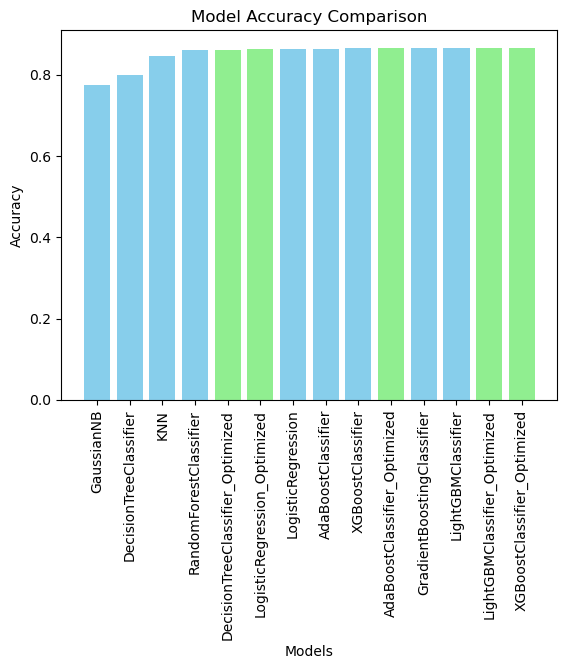

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Making the lists of models and their accuracies to zip
models = ['RandomForestClassifier', 'LogisticRegression', 'LogisticRegression_Optimized', 'DecisionTreeClassifier', 'DecisionTreeClassifier_Optimized', 'KNN', 'GaussianNB', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'AdaBoostClassifier_Optimized', 'XGBoostClassifier', 'XGBoostClassifier_Optimized', 'LightGBMClassifier', 'LightGBMClassifier_Optimized']
accuracies = [accuracy, accuracy_lr, accuracy_lr_optimized, accuracy_dt, accuracy_dt_optimized, accuracy_knn, accuracy_nb, accuracy_gb, accuracy_ab, accuracy_ab_optimized, accuracy_xgb, accuracy_xgb_optimized, accuracy_lgb, accuracy_lgb_optimized]

# Combine models and accuracies into a list of tuples
model_accuracy = list(zip(models, accuracies))

# Sort the models based on accuracy (from lowest to highest)
model_accuracy.sort(key=lambda x: x[1])

# Unzip the sorted models and accuracies
sorted_models, sorted_accuracies = zip(*model_accuracy)

# Changing the colors of the columns so the the optimized ones are light green
colors = ['skyblue' if '_Optimized' not in model else 'lightgreen' for model in sorted_models]

# Plotting the sorted columns
plt.bar(sorted_models, sorted_accuracies, color= colors)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

# Rotating the titles to make it more legible
plt.xticks(rotation=90)

plt.show()

Confirming results of the "best" model

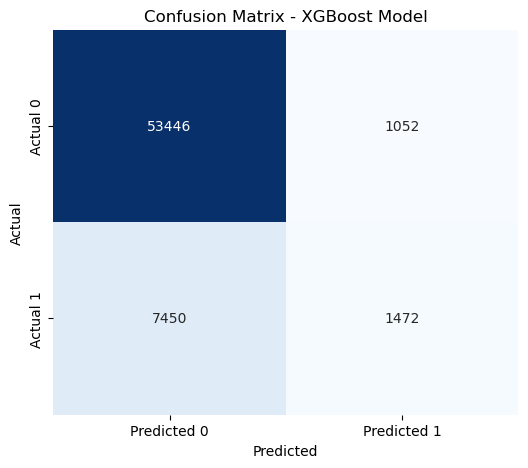

In [14]:
# Confusion matrix for XGBoost
cm_df = pd.DataFrame(cm_xgb_optimized, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Seaborn Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix - XGBoost Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Looking at Sensitivity:

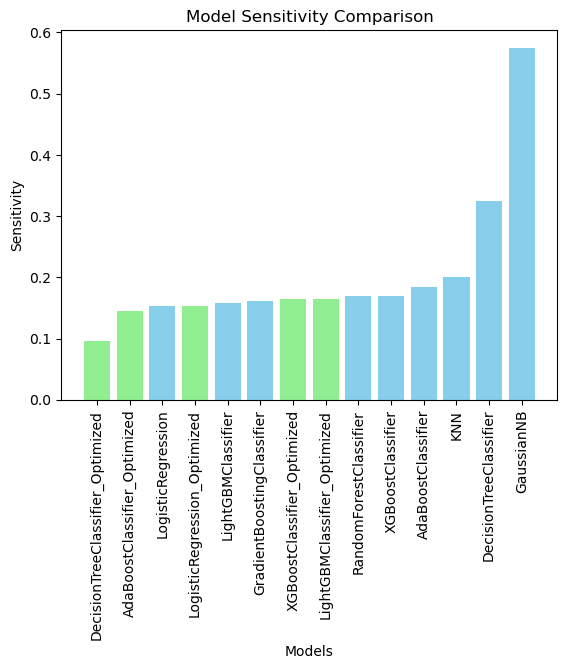

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Making the lists of models and their sensitivities to zip
models = ['RandomForestClassifier', 'LogisticRegression', 'LogisticRegression_Optimized', 'DecisionTreeClassifier', 'DecisionTreeClassifier_Optimized', 'KNN', 'GaussianNB', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'AdaBoostClassifier_Optimized', 'XGBoostClassifier', 'XGBoostClassifier_Optimized', 'LightGBMClassifier', 'LightGBMClassifier_Optimized']
sensitivities = [sensitivity_rf, sensitivity_lr, sensitivity_lr_opt, sensitivity_dt, sensitivity_dt_opt, sensitivity_knn, sensitivity_nb, sensitivity_gb, sensitivity_ab, sensitivity_ab_opt, sensitivity_xgb, sensitivity_xgb_opt, sensitivity_lgb, sensitivity_lgb_opt]

# Combine models and sensitivities into a list of tuples
model_sensitivity = list(zip(models, sensitivities))

# Sort the models based on sensitivity (from lowest to highest)
model_sensitivity.sort(key=lambda x: x[1])

# Unzip the sorted models and accuracies
sorted_models, sorted_sensitivities = zip(*model_sensitivity)

# Changing the colors of the columns so the the optimized ones are light green
colors = ['skyblue' if '_Optimized' not in model else 'lightgreen' for model in sorted_models]

# Plotting the sorted columns
plt.bar(sorted_models, sorted_sensitivities, color= colors)
plt.xlabel('Models')
plt.ylabel('Sensitivity')
plt.title('Model Sensitivity Comparison')

# Rotating the titles to make it more legible
plt.xticks(rotation=90)

plt.show()

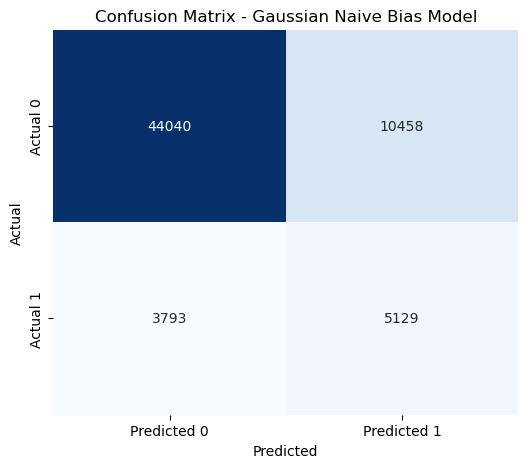

In [20]:
# Confusion matrix for GaussianNB
cm_df = pd.DataFrame(cm_nb, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Seaborn Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix - Gaussian Naive Bias Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

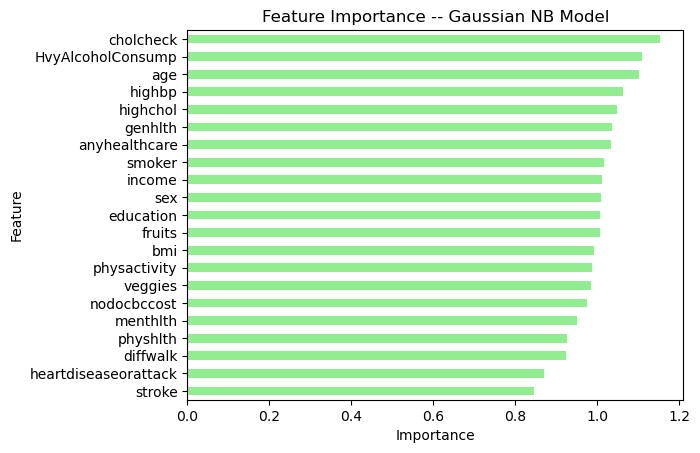

In [24]:
# Extract means and variances from the model
means = nb_model.theta_  # Mean of each feature for each class
variances = nb_model.var_  # Variance of each feature for each class

# For each feature, calculate the "importance" as the sum of absolute values of mean and variance
feature_importance = []
for i, feature in enumerate(X.columns):
    # Using the sum of the absolute values of the mean and variance for each feature
    importance = abs(means[0, i]) + abs(variances[0, i])  # For class 0, could also aggregate over classes
    feature_importance.append((feature, importance))

# Create a DataFrame for easy visualization
importances_df = pd.DataFrame(feature_importance, columns=['Feature', 'Importance'])

# Sort the features by importance
importances_sorted = importances_df.sort_values(by='Importance', ascending=True)

# Plot the sorted feature importances
importances_sorted.plot(kind='barh', x='Feature', y='Importance', color='lightgreen', title='Feature Importance -- Gaussian NB Model', xlabel='Importance', ylabel='Feature', legend=False)
plt.show()

In [29]:
# --- Model 6.5: Optimized Naive Bayes/GaussianNB Model ---

# Define the parameter grid
param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

nb_grid_search = GridSearchCV(GaussianNB(), param_grid_nb, cv=5, n_jobs=-1, scoring='accuracy')
nb_grid_search.fit(X_train_scaled, y_train)

nb_model_opt = nb_grid_search.best_estimator_

# Make predictions and evaluate model
predictions_nb_opt = nb_model_opt.predict(X_test_scaled)
accuracy_nb_opt = accuracy_score(y_test, predictions_nb_opt)
cm_nb_opt = confusion_matrix(y_test, predictions_nb_opt)
cm_df_nb_opt = pd.DataFrame(cm_nb, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_nb_opt = classification_report(y_test, predictions_nb_opt)

# Calculate AUC: ROC-AUC score for binary classification
auc_nb_opt = roc_auc_score(y_test, nb_model_opt.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_nb_opt.ravel()
sensitivity_nb_opt = TP / (TP + FN)
specificity_nb_opt = TN / (TN + FP)

# Log the results of the Optimized GaussianNB Model to csv
log_results_to_csv('Optimized GaussianNB', nb_grid_search.best_estimator_, accuracy_nb_opt, auc_nb_opt, sensitivity_nb_opt, specificity_nb_opt, cm_df_nb_opt, classification_rep_nb_opt)